In [1]:
import sys, os, glob
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import warnings
from scipy.stats import percentileofscore

# logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.DEBUG)
logging.basicConfig(stream=sys.stdout, format='%(asctime)s - %(levelname)s - %(message)s', level=logging.INFO)

%matplotlib inline
font = {'family' : 'Arial',
        'size'   : 7}
matplotlib.rc('font', **font)
plt.rcParams['svg.fonttype'] = 'none'
# plt.rcParams['pdf.fonttype'] = 42

# make a folder to store figures if not already there
!mkdir ../jupyter_figures


mkdir: ../jupyter_figures: File exists


In [2]:
def plot_cum_dist(data, n_bins=None, output_fig_path=None,
                  x_ticks=None, y_ticks=None, y_log_scale=False,
                  x_max=None, y_max=None,
                  fig_width=1.0, fig_height=1.0,
                  clipping_removal=True, axis_off=False):
    '''Plot a black curve and a blue histogram representing cumulative distribution of data
    '''
    
    fig = plt.figure(figsize=(fig_width, fig_height), dpi=300)
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    
    ax = sns.kdeplot(data, cumulative=True, linewidth=0.8, legend=False, color='k')
    
    plt.hist(data, bins=n_bins, cumulative=True, density=True, color='Blue', rwidth=.9, alpha=.6)
#     ax = sns.distplot(data, kde=False, hist_kws={'cumulative': True, 'rwidth': .9, 'alpha': .5}, norm_hist=True, color='Blue')

    plt.ylabel("Cumulative\nfraction of data")
    
    if x_ticks is not None:
        plt.xticks(x_ticks)
        
    if x_max is not None:
        plt.xlim( [min(data), x_max] )
        
    if y_log_scale == True:
    # seems to have issues, may address in the future
        ax.set(yscale="log")
    else:
        if y_ticks is not None:
            plt.yticks(y_ticks)

        if y_max is not None:
            plt.ylim( [0, y_max] )

    if clipping_removal == True:
        # The following removes excessive clipping to facilitate detailing
        # of line widths and colors etc. in illustrator
        # *** Note that removing clipping causes issues for log scale ***
        for o in fig.findobj():
            o.set_clip_on(False)
        for o in ax.findobj():
            o.set_clip_on(False)

    if axis_off == True:
        plt.axis("off")
        
    if output_fig_path is not None:
        plt.savefig(output_fig_path)
    
    return ax

def plot_dist(data, output_fig_path=None,
              kde=True, n_bins=None, norm_hist=True,
              x_ticks=None, x_max=None, x_label=None,
              y_ticks=None, y_max=None, y_log_scale=False,
              fig_width=1.0, fig_height=1.0,
              clipping_removal=True, axis_off=False):
    '''Plot a black curve and a blue histogram representing cumulative distribution of data
    '''
    
    fig = plt.figure(figsize=(fig_width, fig_height), dpi=300)
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
    
    if kde==True:
        ax = sns.kdeplot(data, cumulative=False, linewidth=0.8, legend=False, color='k')
    
    plt.hist(data, bins=n_bins, cumulative=False, density=norm_hist, color='Blue', rwidth=.9, alpha=.6)
#     ax = sns.distplot(data, kde=False, hist_kws={'cumulative': False, 'rwidth': .9, 'alpha': .6}, norm_hist=norm_hist, color='Blue')
    
    if norm_hist == True:
        plt.ylabel("Probablity density")
    else:
        plt.ylabel("Count of data")
    
    if x_label is not None:
        plt.xlabel(x_label)
        
    if x_ticks is not None:
        plt.xticks(x_ticks)
        
    if x_max is not None:
        plt.xlim( [min(data), x_max] )
        
    if y_log_scale == True:
    # seems to have issues, may address in the future
        ax.set(yscale="log")
    else:
        if y_ticks is not None:
            plt.yticks(y_ticks)

        if y_max is not None:
            plt.ylim( [0, y_max] )

    if clipping_removal == True:
        # The following removes excessive clipping to facilitate detailing
        # of line widths and colors etc. in illustrator
        # *** Note that removing clipping causes issues for log scale ***
        for o in fig.findobj():
            o.set_clip_on(False)
        for o in ax.findobj():
            o.set_clip_on(False)
    
    if axis_off == True:
        plt.axis("off")
    
    if output_fig_path is not None:
        plt.savefig(output_fig_path)
    
    return ax

def plot_track_distance_to_surface(df, output_fig_path=None,
                                   N_tracks=200, fig_width=1.5, fig_height=1.0, rand_seed=7):
    assert 'TrackID' in df.columns
    assert 'Distance' in df.columns
    
    fig = plt.figure(figsize=(1.5, 1.0), dpi=300)
    ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

    tracks = df.TrackID.unique()
    # Plot N randomly chosen tracks to show most movement of surface-proximal tracks move within the surface
    np.random.seed(rand_seed)
    track_count = 0
    for i in np.random.randint(0, len(tracks), N_tracks*100):
        # Get the data frame subset of current track
        df_temp = df[ df.TrackID==tracks[i] ]
        # Filter out short tracks
        if len(df_temp)<36:
            continue
        # Filter out very long tracks that tends to contain errors
        if len(df_temp)>120:
            continue

        # Filter out tracks with positive distance,
        # which are likely outside of the epithelial surface
        if pd.Series(df_temp.Distance>-3).any():
            continue

        # Normalize the x-axis to make the plot cleaner
        x = np.arange(len(df_temp))/(len(df_temp)-1)
#         plt.plot(x, df_temp.Distance, alpha=0.2, lw=0.4)
        plt.plot(x, df_temp.Distance, alpha=0.1, lw=0.4, color='k')

        track_count += 1
        if track_count > N_tracks:
            break

    # Check whether desired number of plot were obtained
    assert track_count == N_tracks + 1
    
    plt.xlabel('Relative track time')
    plt.ylabel("Distance to\nepithelial surface")
    plt.ylim( [-50, 0] )
    plt.yticks( [-45, -30, -15, 0])

    # The following removes excessive clipping to facilitate detailing of line widths and colors etc in illustrator
    for o in fig.findobj():
        o.set_clip_on(False)
    for o in ax.findobj():
        o.set_clip_on(False)
    
    if output_fig_path is not None:
        plt.savefig(output_fig_path)

    return ax


In [3]:
track_file = '../data/imaris-overall-tracking-data/Tracks-surface-proximal/2020-01-25-K14R-HisG-2photon-25x-2-denoised_Shortest_Distance_to_Surfaces_Surfaces=Surfaces_1.csv'
output_prefix = '2020-01-25-K14R-HisG-2photon-25x-2-denoised-surface-proximal-tracks'
df = pd.read_csv(track_file, skiprows=3)
df.rename(columns={'Shortest Distance to Surfaces':'Distance'}, inplace=True)
df.head()


,Distance,Unit,Category,Surfaces,Time,TrackID,ID,Unnamed: 7
0,-3.79688,um,Spot,Surfaces 1,25,1000000000,0,NaN
1,-6.42798,um,Spot,Surfaces 1,25,1000000001,1,NaN
2,-6.48458,um,Spot,Surfaces 1,25,1000000002,2,NaN
3,-7.88086,um,Spot,Surfaces 1,25,1000000003,3,NaN
4,-7.83211,um,Spot,Surfaces 1,25,1000000004,4,NaN


In [4]:
df.describe()

,Distance,Time,TrackID,ID,Unnamed: 7
count,392672.000000,392672.000000,3.926720e+05,392672.000000,0.0
mean,-11.618291,162.885383,1.000157e+09,196335.500000,NaN
std,6.051425,75.696301,1.131036e+05,113354.786788,NaN
min,-47.325500,25.000000,1.000000e+09,0.000000,NaN
25%,-14.591600,98.000000,1.000053e+09,98167.750000,NaN
50%,-9.694420,167.000000,1.000153e+09,196335.500000,NaN
75%,-7.631032,229.000000,1.000250e+09,294503.250000,NaN
max,30.954000,289.000000,1.000383e+09,392671.000000,NaN


In [5]:
# Filter out tracks that go outside of the surface
# These tracks are mesenchyme tracks closely delineating the surface
# that got selected when the simple minimal distance criteria was used to filter tracks in Imaris
tracks_to_drop = []
for track in df.TrackID.unique():
    df_temp = df[df.TrackID==track]
    track_max_dist_temp = np.max(df_temp.Distance)
    if track_max_dist_temp >= 0:
        tracks_to_drop.append(track)
print("Total number of tracks to drop: ", len(tracks_to_drop))

df_filtered = df[~df.TrackID.isin(tracks_to_drop)]


Total number of tracks to drop:  59


In [6]:
print("Total number of tracks before filtering: ", df.TrackID.nunique())
print("Total number of spots before filtering: ", len(df))
print("Total number of tracks after filtering: ", df_filtered.TrackID.nunique())
print("Total number of spots after filtering: ", len(df_filtered))

Total number of tracks before filtering:  14867
Total number of spots before filtering:  392672
Total number of tracks after filtering:  14808
Total number of spots after filtering:  389899


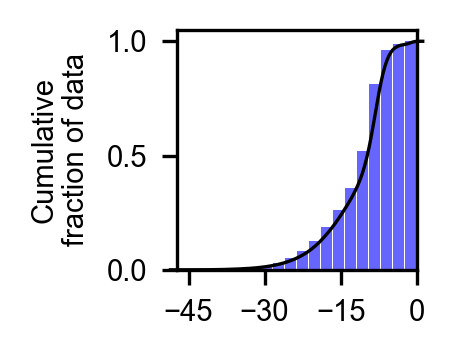

In [7]:
output_file_name = '../jupyter_figures/' + output_prefix + '-CDF-spot-distance-to-surface.svg'
plot_cum_dist(df_filtered.Distance, output_fig_path=output_file_name, n_bins=20,
              x_max=0, x_ticks=[-45, -30, -15, 0], y_ticks=[0.0, 0.5, 1.0])


In [8]:
# Find out at which value the cumulative fraction reaches 1.0
np.percentile(df_filtered.Distance, 100)


-0.0646366

In [9]:
# Find the corresponding percentile of specified value
percentileofscore(df_filtered.Distance, -15)


23.774233840045756

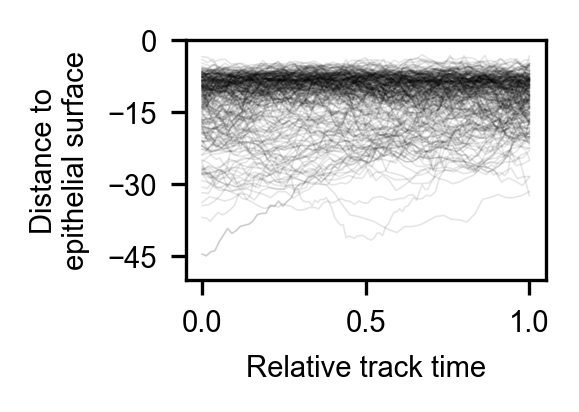

In [10]:
output_file_name = '../jupyter_figures/' + output_prefix + '-line-plot-track-distance-to-surface-N250.svg'
plot_track_distance_to_surface(df_filtered, output_fig_path=output_file_name, N_tracks=250)

# output_file_name = '../jupyter_figures/' + output_prefix + '-line-plot-track-distance-to-surface-N200.svg'
# plot_track_distance_to_surface(df_filtered, output_fig_path=output_file_name, N_tracks=200)

# output_file_name = '../jupyter_figures/' + output_prefix + '-line-plot-track-distance-to-surface-N500.svg'
# plot_track_distance_to_surface(df_filtered, output_fig_path=output_file_name, N_tracks=500)


In [11]:
# Read in data of track duration for all tracks
track_file = '../data/imaris-overall-tracking-data/Tracks-all/2020-01-25-K14R-HisG-2photon-25x-4-denoised_Track_Duration.csv'
df_all = pd.read_csv(track_file, skiprows=3)
df_all.rename(columns={'Track Duration':'Track_Duration'}, inplace=True)
df_all.head()

# Read in data of track duration for epithelial tracks
track_file = '../data/imaris-overall-tracking-data/Tracks-epithelial/2020-01-25-K14R-HisG-2photon-25x-4-denoised_Track_Duration.csv'
df_epi = pd.read_csv(track_file, skiprows=3)
df_epi.rename(columns={'Track Duration':'Track_Duration'}, inplace=True)
df_epi.head()

# Read in data of track duration for surface-proximal tracks
track_file = '../data/imaris-overall-tracking-data/Tracks-surface-proximal/2020-01-25-K14R-HisG-2photon-25x-4-denoised_Track_Duration.csv'
df_surf = pd.read_csv(track_file, skiprows=3)
df_surf.rename(columns={'Track Duration':'Track_Duration'}, inplace=True)
df_surf.head()


,Track_Duration,Unit,Category,ID,Unnamed: 4
0,1.33372,h,Track,1000000000,NaN
1,1.33372,h,Track,1000000001,NaN
2,1.66681,h,Track,1000000002,NaN
3,1.91664,h,Track,1000000003,NaN
4,7.91669,h,Track,1000000004,NaN


In [12]:
# Find the corresponding percentile of specified value
percentileofscore(df_all.Track_Duration, 18.0)
# Identify the percentile
np.percentile(df_all.Track_Duration, 100)
# np.median(df_all.Track_Duration)


22.0003

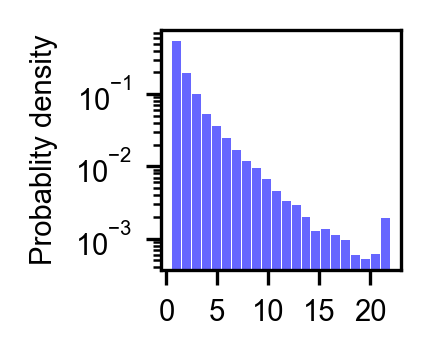

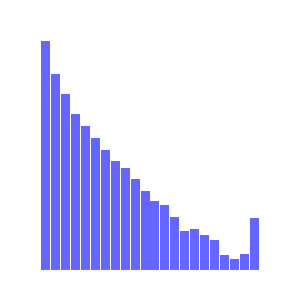

In [13]:
output_prefix = '2020-01-25-K14R-HisG-2photon-25x-4-denoised-all-tracks'
output_file_name = '../jupyter_figures/' + output_prefix + '-Track-Duration-Distribution-y-log-with-clipping.svg'
plot_dist(df_all.Track_Duration, output_fig_path=output_file_name,
          n_bins=22, y_log_scale=True, x_ticks=[0, 5, 10, 15, 20], kde=False, clipping_removal=False)


output_prefix = '2020-01-25-K14R-HisG-2photon-25x-4-denoised-all-tracks'
output_file_name = '../jupyter_figures/' + output_prefix + '-Track-Duration-Distribution-y-log.png'
plot_dist(df_all.Track_Duration, output_fig_path=output_file_name,
          n_bins=22, y_log_scale=True, x_ticks=[0, 5, 10, 15, 20], kde=False, clipping_removal=False, axis_off=True)


In [14]:
# Read in data of mean track speed for all tracks
track_file = '../data/imaris-overall-tracking-data/Tracks-all/2020-01-25-K14R-HisG-2photon-25x-4-denoised_Track_Speed_Mean.csv'
df_all = pd.read_csv(track_file, skiprows=3)
df_all.rename(columns={'Track Speed Mean':'Mean_Track_Speed'}, inplace=True)
df_all.head()

# Read in data of mean track speed for epithelial tracks
track_file = '../data/imaris-overall-tracking-data/Tracks-epithelial/2020-01-25-K14R-HisG-2photon-25x-4-denoised_Track_Speed_Mean.csv'
df_epi = pd.read_csv(track_file, skiprows=3)
df_epi.rename(columns={'Track Speed Mean':'Mean_Track_Speed'}, inplace=True)
df_epi.head()

# Read in data of mean track speed for surface-proximal tracks
track_file = '../data/imaris-overall-tracking-data/Tracks-surface-proximal/2020-01-25-K14R-HisG-2photon-25x-4-denoised_Track_Speed_Mean.csv'
df_surf = pd.read_csv(track_file, skiprows=3)
df_surf.rename(columns={'Track Speed Mean':'Mean_Track_Speed'}, inplace=True)
df_surf.head()


,Mean_Track_Speed,Unit,Category,ID,Unnamed: 4
0,14.7511,um/h,Track,1000000000,NaN
1,16.3517,um/h,Track,1000000001,NaN
2,17.6142,um/h,Track,1000000002,NaN
3,16.1624,um/h,Track,1000000003,NaN
4,16.3708,um/h,Track,1000000004,NaN


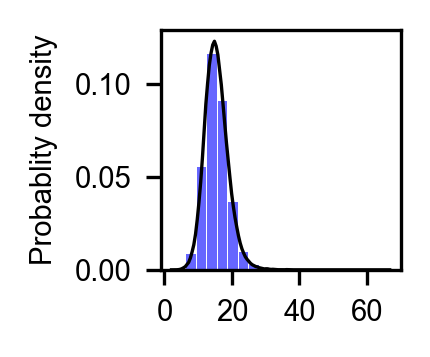

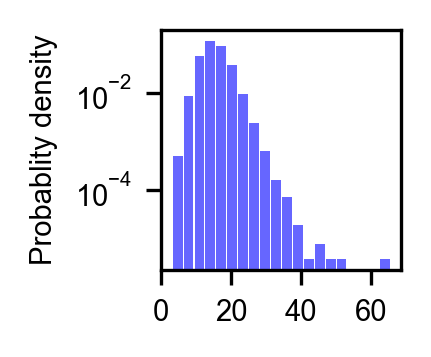

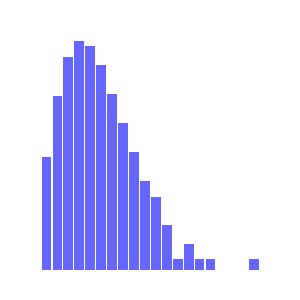

In [15]:
# Plot the distribution of all three track selections
output_prefix = '2020-01-25-K14R-HisG-2photon-25x-4-denoised'
output_file_name = '../jupyter_figures/' + output_prefix + '-all-tracks-Mean-Track-Speed-Distribution.svg'
plot_dist(df_all.Mean_Track_Speed, n_bins=20,
#           x_ticks=[0, 25, 50, 75], x_max=75,
          x_ticks=[0, 20, 40, 60],
          output_fig_path=output_file_name)

output_file_name = '../jupyter_figures/' + output_prefix + '-all-tracks-Mean-Track-Speed-Distribution-y-log.svg'
plot_dist(df_all.Mean_Track_Speed, n_bins=20,
          x_ticks=[0, 20, 40, 60],
          y_log_scale=True, kde=False,
          output_fig_path=output_file_name,
          clipping_removal=False)

output_file_name = '../jupyter_figures/' + output_prefix + '-all-tracks-Mean-Track-Speed-Distribution-y-log.png'
plot_dist(df_all.Mean_Track_Speed, n_bins=20,
          x_ticks=[0, 20, 40, 60],
          y_log_scale=True, kde=False,
          output_fig_path=output_file_name,
          clipping_removal=False, axis_off=True)


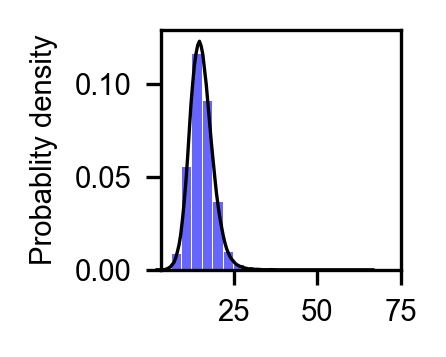

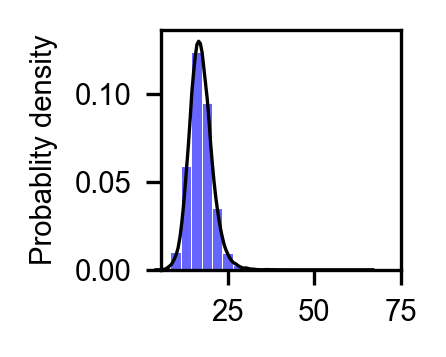

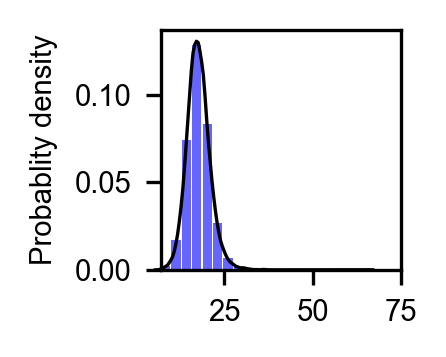

In [16]:
# Plot the distribution of all three track selections
plot_dist(df_all.Mean_Track_Speed, n_bins=20, x_ticks=[0, 25, 50, 75], x_max=75)
plot_dist(df_epi.Mean_Track_Speed, n_bins=20, x_ticks=[0, 25, 50, 75], x_max=75)
plot_dist(df_surf.Mean_Track_Speed, n_bins=20, x_ticks=[0, 25, 50, 75], x_max=75)


In [17]:
print('Track number of all tracks: ', len(df_all))
print('Track number of epithelial tracks: ', len(df_epi))
print('Track number of surface-proximal epithelial tracks: ', len(df_surf))

Track number of all tracks:  83813
Track number of epithelial tracks:  22050
Track number of surface-proximal epithelial tracks:  11781


In [18]:
# Check whether track ID was inherited: it was NOT
len(set(df_epi.ID.unique()).intersection(set(df_surf.ID.unique())))

1122

In [19]:
# Read in track straightness data for all tracks (x,y,z positions for each spot)
track_file = '../data/imaris-overall-tracking-data/Tracks-all/2020-01-25-K14R-HisG-2photon-25x-4-denoised_Track_Straightness.csv'
df_all = pd.read_csv(track_file, skiprows=3)
df_all.rename(columns={'Track Straightness':'Track_Straightness'}, inplace=True)
df_all.head()

# Read in track straightness data for all tracks (x,y,z positions for each spot)
track_file = '../data/imaris-overall-tracking-data/Tracks-epithelial/2020-01-25-K14R-HisG-2photon-25x-4-denoised_Track_Straightness.csv'
df_epi = pd.read_csv(track_file, skiprows=3)
df_epi.rename(columns={'Track Straightness':'Track_Straightness'}, inplace=True)
df_epi.head()

# Read in track straightness data for all tracks (x,y,z positions for each spot)
track_file = '../data/imaris-overall-tracking-data/Tracks-surface-proximal/2020-01-25-K14R-HisG-2photon-25x-4-denoised_Track_Straightness.csv'
df_surf = pd.read_csv(track_file, skiprows=3)
df_surf.rename(columns={'Track Straightness':'Track_Straightness'}, inplace=True)
df_surf.head()


,Track_Straightness,Unit,Category,ID,Unnamed: 4
0,0.540079,NaN,Track,1000000000,NaN
1,0.238043,NaN,Track,1000000001,NaN
2,0.256855,NaN,Track,1000000002,NaN
3,0.426676,NaN,Track,1000000003,NaN
4,0.286270,NaN,Track,1000000004,NaN


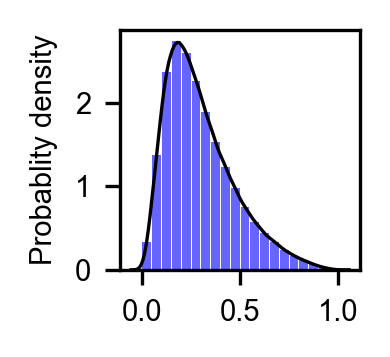

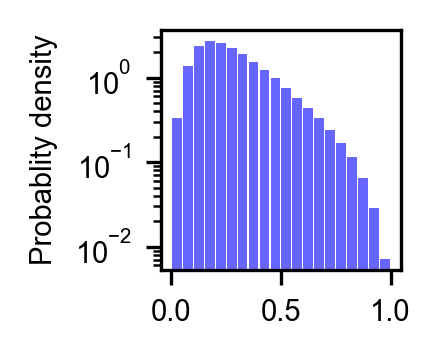

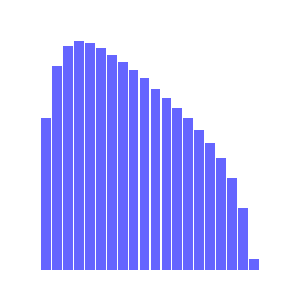

In [20]:
output_prefix = '2020-01-25-K14R-HisG-2photon-25x-4-denoised'

output_file_name = '../jupyter_figures/' + output_prefix + '-all-tracks-Track-Straightness-Distribution.svg'
plot_dist(df_all.Track_Straightness, n_bins=20,
          x_ticks=[0, 0.5, 1.0],
          output_fig_path=output_file_name)

output_file_name = '../jupyter_figures/' + output_prefix + '-all-tracks-Track-Straightness-Distribution-y-log.svg'

plot_dist(df_all.Track_Straightness, n_bins=20,
          x_ticks=[0, 0.5, 1.0],
          y_log_scale=True, kde=False,
          output_fig_path=output_file_name,
          clipping_removal=False)

output_file_name = '../jupyter_figures/' + output_prefix + '-all-tracks-Track-Straightness-Distribution-y-log.png'

plot_dist(df_all.Track_Straightness, n_bins=20,
          x_ticks=[0, 0.5, 1.0],
          y_log_scale=True, kde=False,
          output_fig_path=output_file_name,
          clipping_removal=False, axis_off=True)


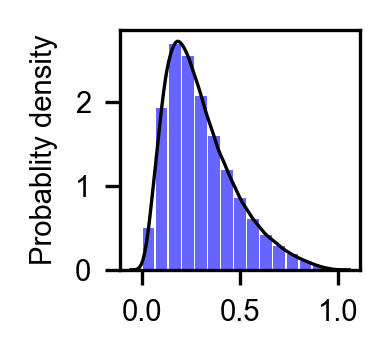

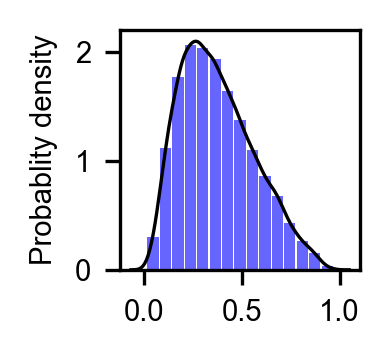

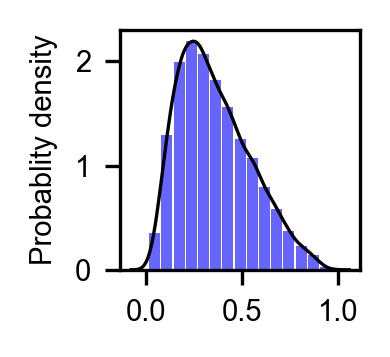

In [21]:
# Plot the distribution of all three track selections
# plot_dist(df_all.Track_Straightness)
plot_dist(df_all.Track_Straightness, n_bins=15, x_ticks=[0, 0.5, 1.0])
plot_dist(df_epi.Track_Straightness, n_bins=15, x_ticks=[0, 0.5, 1.0])
plot_dist(df_surf.Track_Straightness, n_bins=15, x_ticks=[0, 0.5, 1.0])


In [22]:
# Note that spot ID was inherited in the filtering of Imaris,
# which provides a way to select complement set of tracks
#
# Read in the most raw form of data for all tracks (x,y,z positions for each spot)
track_file = '../data/imaris-overall-tracking-data/Tracks-all/2020-01-25-K14R-HisG-2photon-25x-4-denoised_Position.csv'
df_all = pd.read_csv(track_file, skiprows=3)
df_all.rename(columns={'Position X':'x', 'Position Y':'y', 'Position Z':'z'}, inplace=True)
df_all.head()


,x,y,z,Unit,Category,Collection,Time,TrackID,ID,Unnamed: 9
0,7448.51,-3991.46,1032.25,um,Spot,Position,25,1000000003,3,NaN
1,7540.38,-3988.82,1032.25,um,Spot,Position,25,1000000004,4,NaN
2,7502.64,-3988.28,1032.25,um,Spot,Position,25,1000000005,5,NaN
3,7556.84,-3981.88,1032.25,um,Spot,Position,25,1000000008,8,NaN
4,7510.12,-3974.42,1032.25,um,Spot,Position,25,1000000009,9,NaN


In [23]:
by_time = df_all.groupby('Time')
# spot_count_by_time = by_time['ID'].describe()['count']
# spot_count_by_time

track_count_by_time = by_time['TrackID'].describe()['count']

2020-04-16 11:00:08,202 - INFO - NumExpr defaulting to 8 threads.


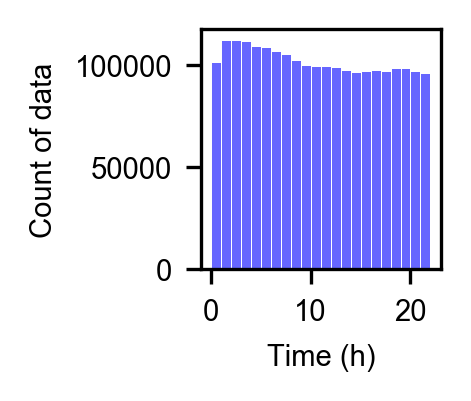

In [24]:
output_prefix = '2020-01-25-K14R-HisG-2photon-25x-4-denoised'
output_file_name = '../jupyter_figures/' + output_prefix + '-tracked-cell-count-over-time.svg'
plot_dist( (df_all.Time - 24) / 12, output_fig_path=output_file_name,
         kde=False, n_bins=22, norm_hist=False,
         x_ticks=[0, 10, 20], x_label='Time (h)')


In [25]:
# Read in the speed data for all tracks (x,y,z positions for each spot)
track_file = '../data/imaris-overall-tracking-data/Tracks-all/2020-01-25-K14R-HisG-2photon-25x-4-denoised_Speed.csv'
df_all_speed = pd.read_csv(track_file, skiprows=3)
# df_all_speed.rename(columns={'Shortest Distance to Surfaces':'Distance'}, inplace=True)
print(df_all_speed.shape)
df_all_speed.head()


(2238132, 7)


,Speed,Unit,Category,Time,TrackID,ID,Unnamed: 6
0,24.07070,um/h,Spot,25,1000000003,3,NaN
1,32.56920,um/h,Spot,25,1000000004,4,NaN
2,4.36720,um/h,Spot,25,1000000005,5,NaN
3,2.50779,um/h,Spot,25,1000000008,8,NaN
4,8.96137,um/h,Spot,25,1000000009,9,NaN


In [26]:
# Read in the distance to surface data for all tracks
track_file = '../data/imaris-overall-tracking-data/Tracks-all/2020-01-25-K14R-HisG-2photon-25x-4-denoised_Shortest_Distance_to_Surfaces_Surfaces=Surfaces_1.csv'
df_all_dist_surf = pd.read_csv(track_file, skiprows=3)
df_all_dist_surf.rename(columns={'Shortest Distance to Surfaces':'Distance'}, inplace=True)
df_all_dist_surf.head()

,Distance,Unit,Category,Surfaces,Time,TrackID,ID,Unnamed: 7
0,246.502,um,Spot,Surfaces 1,25,1000000003,3,NaN
1,215.614,um,Spot,Surfaces 1,25,1000000004,4,NaN
2,223.857,um,Spot,Surfaces 1,25,1000000005,5,NaN
3,205.875,um,Spot,Surfaces 1,25,1000000008,8,NaN
4,208.587,um,Spot,Surfaces 1,25,1000000009,9,NaN


In [27]:
len(set(df_all.ID.unique()).intersection(set(df_all_dist_surf.ID.unique())))

2238132

In [28]:
df_all_dist_surf = df_all_dist_surf.loc[ :, ['Distance', 'ID']]
df_all_dist_surf.head()
df = df_all.merge(df_all_dist_surf, on='ID')


In [29]:
# Select track IDs based on their distance to surface
### !!! Note: this one is computatitionally intensive, could take many minutes !!! ###
tracks_epi = []
tracks_surf = []
for track in df.TrackID.unique():
    df_temp = df[df.TrackID==track]
    if np.max(df_temp.Distance) <=0:
        tracks_epi.append(track)
        if np.min(df_temp.Distance) >=-15:
            tracks_surf.append(track)
print("Total number of epithelial tracks: ", len(tracks_epi))
print("Total number of surface epithelial tracks: ", len(tracks_surf))


Total number of epithelial tracks:  23441
Total number of surface epithelial tracks:  9200


In [30]:
print("Total number of all tracks: ", df.TrackID.nunique())
print("Total number of all spots: ", df.ID.nunique())

df_epi = df[df.TrackID.isin(tracks_epi)]
print("Total number of epithelial tracks: ", df_epi.TrackID.nunique())
print("Total number of spots in epithelial cell tracks: ", df_epi.ID.nunique())

df_mes = df[~df.TrackID.isin(tracks_epi)]
print("Total number of mesenchymal tracks: ", df_mes.TrackID.nunique())
print("Total number of spots in mesenchymal tracks: ", df_mes.ID.nunique())

df_surf = df_epi[df_epi.TrackID.isin(tracks_surf)]
print("Total number of surface-proximal epithelial tracks: ", df_surf.TrackID.nunique())
print("Total number of spots in surface-proximal epithelial cell tracks: ", df_surf.ID.nunique())

df_int = df_epi[~df_epi.TrackID.isin(tracks_surf)]
print("Total number of interior epithelial tracks: ", df_int.TrackID.nunique())
print("Total number of spots in interior epithelial cell tracks: ", df_int.ID.nunique())


Total number of all tracks:  83813
Total number of all spots:  2238132
Total number of epithelial tracks:  23441
Total number of spots in epithelial cell tracks:  497437
Total number of mesenchymal tracks:  60372
Total number of spots in mesenchymal tracks:  1740695
Total number of surface-proximal epithelial tracks:  9200
Total number of spots in surface-proximal epithelial cell tracks:  172553
Total number of interior epithelial tracks:  14241
Total number of spots in interior epithelial cell tracks:  324884


In [31]:
# Read in data of mean track speed for all tracks
track_file = '../data/imaris-overall-tracking-data/Tracks-all/2020-01-25-K14R-HisG-2photon-25x-4-denoised_Track_Speed_Mean.csv'
df_all_speed = pd.read_csv(track_file, skiprows=3)
df_all_speed.rename(columns={'Track Speed Mean':'Mean_Track_Speed'}, inplace=True)

print(df_all_speed.shape)
df_all_speed.head()


(83813, 5)


,Mean_Track_Speed,Unit,Category,ID,Unnamed: 4
0,15.4576,um/h,Track,1000000003,NaN
1,18.5319,um/h,Track,1000000004,NaN
2,12.1088,um/h,Track,1000000005,NaN
3,14.4088,um/h,Track,1000000008,NaN
4,14.1189,um/h,Track,1000000009,NaN


Area ratio at 24 h over 2 h:  1.2683782251311457
Area ratio at 24 h over 2 h:  1.306006713750785
Area ratio at 24 h over 2 h:  1.396597339095625
Area ratio at 24 h over 2 h:  1.368485774362375


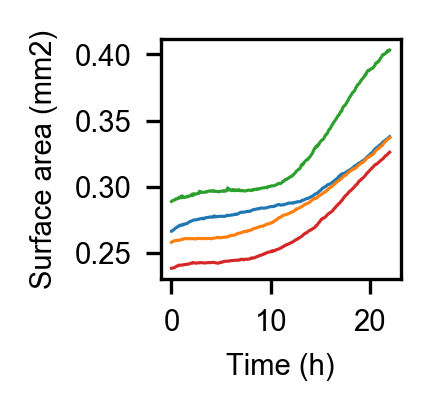

In [32]:
# Plot the 3D surface area increase over time
fig = plt.figure(figsize=(1.0, 1.0), dpi=300)
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])

dataset_list = ['2020-01-25-K14R-HisG-2photon-25x-1-denoised',
               '2020-01-25-K14R-HisG-2photon-25x-2-denoised',
               '2020-01-25-K14R-HisG-2photon-25x-3-denoised',
               '2020-01-25-K14R-HisG-2photon-25x-4-denoised']

for i in range(len(dataset_list)):
    dataset = dataset_list[i]
    f = '../data/imaris-overall-tracking-data/Surface-statistics/' + dataset + '_Area.csv'
    df_area = pd.read_csv(f, skiprows=3)
    df_area.head()
    print('Area ratio at 24 h over 2 h: ', df_area.Area.values[-1]/df_area.Area.values[24])
    time_in_h = [t/12 for t in range(len(df_area)-24)]
    sns.lineplot( time_in_h, df_area.Area[24:] / 1e6, size=0.8, legend=False)

plt.xlabel('Time (h)')
plt.ylabel("Surface area (mm2)")
plt.xticks( [0, 10, 20])


# The following removes excessive clipping to facilitate detailing of line widths and colors etc in illustrator
for o in fig.findobj():
    o.set_clip_on(False)
for o in ax.findobj():
    o.set_clip_on(False)

output_prefix = '2020-01-25-K14R-HisG-2photon-25x'
output_fig_path = '../jupyter_figures/' + output_prefix + '-surface-area-over-time.svg'
plt.savefig(output_fig_path)
